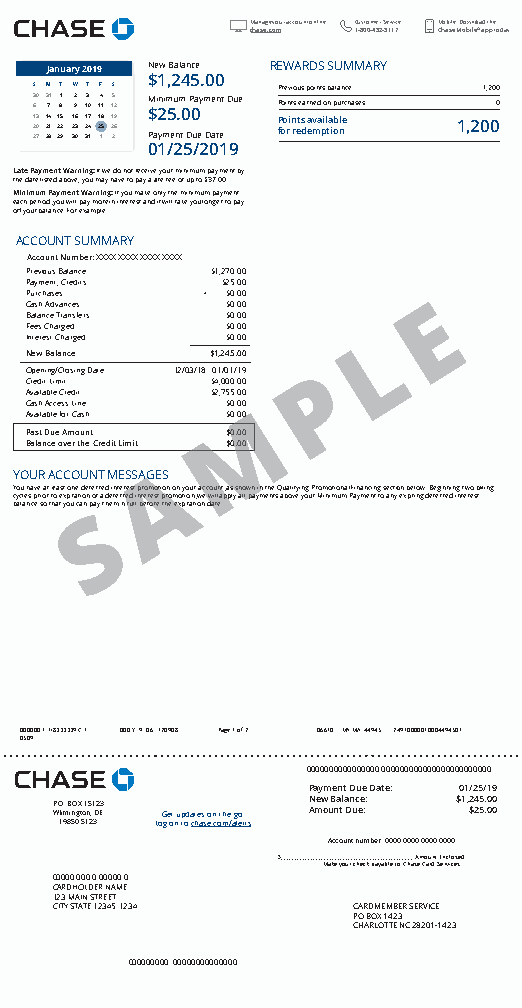

In [129]:
# https://github.com/jsvine/pdfplumber/blob/stable/examples/notebooks/extract-table-nics.ipynb
# https://pypi.org/project/pdfplumber/
# https://www.chase.com/content/dam/chase-ux/documents/digital/resources/paperless_statements_chase_sample.pdf

import pdfplumber
import re
pdf = pdfplumber.open(r"paperless_statements_chase_sample.pdf")
pages = pdf.pages
images = [page.to_image() for page in pages]
images[0] # Opens nicely in jupyter notebook


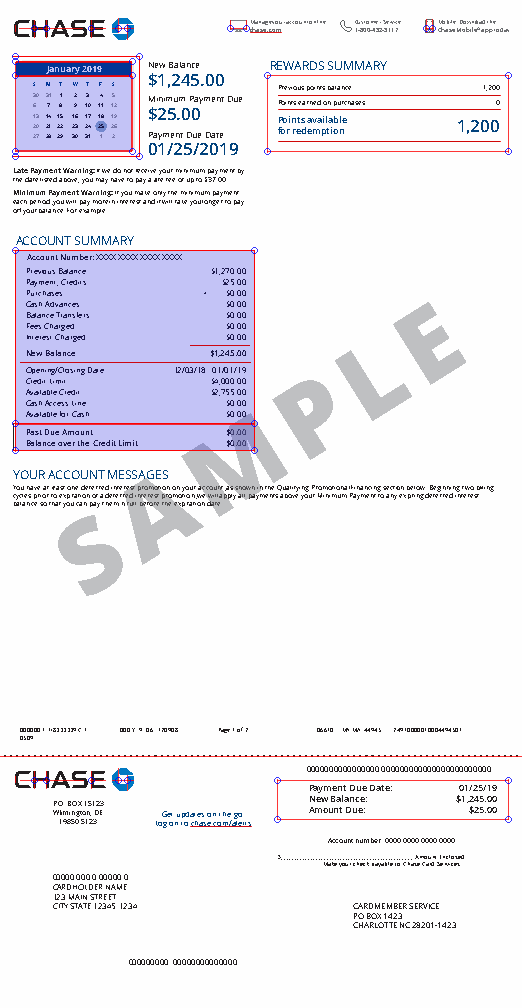

In [130]:
# Return a version of the PageImage with the detected lines (in red), intersections (circles), and tables (light blue) overlaid

images[0].debug_tablefinder(table_settings={}) # See https://pypi.org/project/pdfplumber/#extracting-tables for default values

In [131]:
# Print the text from each of the tables
for table in pages[0].extract_tables(table_settings={}):
    for row in table:
        print(row)
    print()

['January 2019']
['S M T W T F S\n30 31 1 2 3 4 5\n6 7 8 9 10 11 12\n13 14 15 16 17 18 19\n20 21 22 23 24 25 26\n27 28 29 30 31 1 2']

['Account Number: XXXX XXXX XXXX XXXX\nPrevious Balance $1,270.00\nPayment, Credits - $25.00\nPurchases + $0.00\nCash Advances $0.00\nBalance Transfers $0.00\nFees Charged $0.00\nInterest Charged $0.00\nNew Balance $1,245.00\nOpening/Closing Date 12/03/18 - 01/01/19\nCredit Limit $4,000.00\nAvailable Credit $2,755.00\nCash Access Line $0.00\nAvailable for Cash $0.00']
['Past Due Amount $0.00\nBalance over the Credit Limit $0.00']



In [137]:
# Select the account number table: print the text from the table that starts with "Account Number"
for table in pages[0].extract_tables(table_settings={}):
    for row in table:
        if "Account Number" in row[0]:
            print(row)
            # store data in variable
            account_number_data = row
            break

['Account Number: XXXX XXXX XXXX XXXX\nPrevious Balance $1,270.00\nPayment, Credits - $25.00\nPurchases + $0.00\nCash Advances $0.00\nBalance Transfers $0.00\nFees Charged $0.00\nInterest Charged $0.00\nNew Balance $1,245.00\nOpening/Closing Date 12/03/18 - 01/01/19\nCredit Limit $4,000.00\nAvailable Credit $2,755.00\nCash Access Line $0.00\nAvailable for Cash $0.00']


In [143]:
# Split into lines
lines = account_number_data[0].split("\n")  # Access the first element of the list

data = []
for line in lines:
    # Split on first $ or first colon/dash as divider
    match = re.split(r'[:$]', line, maxsplit=1)
    if len(match) == 2:
        key = match[0].strip()
        val = match[1].strip()

        # Clean up money values (remove commas, symbols)
        if re.match(r"[\d,]+\.\d{2}", val.replace("-", "").replace("+", "")):
            val = float(val.replace(",", "").replace("+", "").replace("-", "").strip())
        data.append([key, val])
    else:
        # fallback if no $/colon split (like dates)
        parts = line.split(" ", 1)
        if len(parts) == 2:
            data.append([parts[0], parts[1]])

# Make DataFrame
df = pd.DataFrame(data, columns=["Label", "Value"])
print(df)

                 Label                     Value
0       Account Number       XXXX XXXX XXXX XXXX
1     Previous Balance                    1270.0
2   Payment, Credits -                      25.0
3          Purchases +                       0.0
4        Cash Advances                       0.0
5    Balance Transfers                       0.0
6         Fees Charged                       0.0
7     Interest Charged                       0.0
8          New Balance                    1245.0
9      Opening/Closing  Date 12/03/18 - 01/01/19
10        Credit Limit                    4000.0
11    Available Credit                    2755.0
12    Cash Access Line                       0.0
13  Available for Cash                       0.0


In [163]:
# Export to CSV
# make dir data if it doesn't exitst
import os

if not os.path.exists("data"):
    os.makedirs("data")

df.to_csv(r"data/account_info.csv", index=False)

### Live Statment Considerations
On a live chase bank statement, the only tables that were detected were section titles. On the sample bank statment in this repo, a few were detected. However, column seperation is not consistent for most of the tables in the live statement. Therefore, table extraction will not work and a more concise approach is required.

Two options:
1. Make bounding boxes extract the bounding box text
2. Extract all embedded text and use the `*start*` and `*end*` section annotations (not present on sample bank statement)

### Option 1: Extract text from bounding boxes
Different bank reports have different sizes of tables, therefore this is an inflexible solution.

In [164]:
# Option 1: Extract bbox text

page = pdf.pages[0]

# Tweak these numbers after inspecting the page.
chase_checking_summary_bbox = (0, page.height-492, page.width, page.height-400) # Left, Top, Right, Bottom

im = page.to_image()
im.draw_rect(chase_checking_summary_bbox)
im

# Get all words in this bounding box
# words_in_summary = page.within_bbox(checking_summary_bbox).extract_words()

# Or get raw text
summary_text = page.within_bbox(chase_checking_summary_bbox).extract_text()

# Then it just needs to be parsed...


### Option 2: Use embedded start and end annotations
This is a flexible solution because it will work on tables of various sizes. 
However, the *end* annotation is usually jumbled with the last line of a given table. 

Distinct sections require different parsing, which adds considerably to the complexity of extracting the data from all tables. For this reason, only the Electronic Withdrawal section will be demonstrated.

In [165]:
# Isolate a section of interest

section_text = []

for page in pdf.pages:
    text = page.extract_text()
    if not text:
        continue    # Skip pages with no text

    parts = text.split("*start*electronic withdrawal")
    if len(parts) < 2:
        continue  # Marker not found, skip this page

    section = parts[1].split("*end*electronic withdrawal")[0]
    lines = section.splitlines()
    section_text.extend(lines)

print(section_text)

[]


In [166]:
# Filter the section
import re

section_name = "electronic withdrawal"

bad_strs = ["(continued)", "Page of", section_name, "DATE DESCRIPTION AMOUNT", "Total Electronic Withdrawals"]

filtered_lines = []
for line in section_text:
    if line.strip() == '':                              # skip empty or whitespace-only lines
        continue
    elif re.match(rf"^\d+\s{len(pages)}$", line):       # Removes page numbers by matching 3 or 4 digits where the second digit is the number of pages in the PDF
        continue
    elif any(ignore_str in line for ignore_str in bad_strs): # skip lines that contain any of bad_strs
        continue
    elif "*end*" in line:
        # 1. Split on the first "/"
        left, right = line.split("/", 1)   # left="*end*electro0nic withdraw7al ", right="11 07/11 Online Transfer..."

        # 2. Remove everything except digits from the left
        digits = "".join(ch for ch in left if ch.isdigit())

        # 3. Rebuild the line
        cleaned = f"*end*electronic withdrawal {digits}/{right.strip()}"
        print(cleaned)
    else:
        filtered_lines.append(line)